In [4]:
#Importing libraries and dependencies
import pandas as pd
import requests
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
import datetime as dt
import json
import csv
from dotenv import load_dotenv
import os



In [5]:
# Load environment variables from the correct file
load_dotenv('.env')

# Get API key from .env file
API_KEY = os.getenv('QUIVER_QUANT_API_KEY')

# Setting API endpoint and headers
url = "https://api.quiverquant.com/beta/bulk/congresstrading"
headers = {
    'Accept': "application/json",
    'Authorization': f"Bearer {API_KEY}"
}

# Getting the data
try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # This will raise an exception for HTTP errors
    
    if response.status_code == 200:
        print('200 - Successful application')
        # Load JSON response into the dataframe
        df = pd.DataFrame(response.json())
        print(df.head())
        print(df.dtypes)
    else:
        print(f"Unexpected error: {response.status_code}")
        print(f"Message: {response.text}")
except requests.exceptions.RequestException as e:
    print(f"Error en la solicitud: {e}")
    print(f"complete answer: {response.text if 'response' in locals() else 'No response received'}")


    




200 - Successful application
    Representative BioGuideID  ReportDate TransactionDate  Ticker Transaction  \
0    Mark Dr Green    G000590  2024-10-04      2024-09-30     NGL        Sale   
1  Josh Gottheimer    G000583  2024-10-03      2024-09-27     APH        Sale   
2  Josh Gottheimer    G000583  2024-10-03      2024-09-27      TT        Sale   
3   Rudy Yakym Iii    Y000067  2024-09-26      2024-09-26  MATURE    Purchase   
4  Josh Gottheimer    G000583  2024-10-03      2024-09-26    PYPL    Purchase   

                 Range            House    Amount Party last_modified  
0  $100,001 - $250,000  Representatives  100001.0     R    2024-10-07  
1     $1,001 - $15,000  Representatives    1001.0     D    2024-10-04  
2     $1,001 - $15,000  Representatives    1001.0     D    2024-10-04  
3     $1,001 - $15,000  Representatives    1001.0     R    2024-09-27  
4     $1,001 - $15,000  Representatives    1001.0     D    2024-10-04  
Representative     object
BioGuideID         object


Original shape: (48229, 11)
Shape after removing null values: (48145, 11)
Shape after date conversion: (48145, 11)
Shape after cleaning Amount column: (48145, 11)
Shape after cleaning Range column: (47662, 11)
Shape after removing outliers: (35559, 11)
Shape after removing duplicates: (33387, 11)
Shape after ensuring data consistency: (33352, 11)
Shape after removing Independent party rows: (33300, 11)

First few rows of the cleaned dataframe:
                        Representative BioGuideID ReportDate Ticker  \
TransactionDate                                                       
2012-02-27       MR. ALAN S. LOWENTHAL    L000579 2014-05-15   EP$C   
2012-03-20       MR. ALAN S. LOWENTHAL    L000579 2014-05-15   EP$C   
2012-06-06       MR. ALAN S. LOWENTHAL    L000579 2014-05-15    KSU   
2012-07-24         MS. TAMMY DUCKWORTH    D000622 2014-07-08     PG   
2012-07-26         MS. TAMMY DUCKWORTH    D000622 2014-07-08    CAT   

                Transaction   Range            House  

/var/folders/0_/tgdc8dbx1qg5n2q593jcg_zm0000gn/T/ipykernel_17445/2106799105.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')
/var/folders/0_/tgdc8dbx1qg5n2q593jcg_zm0000gn/T/ipykernel_17445/2106799105.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')
/var/folders/0_/tgdc8dbx1qg5n2q593jcg_zm0000gn/T/ipykernel_17445/2106799105.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s


Cleaned data saved to all_congress_cleaned_data.csv

Time series data prepared. Shape: (4597,)

First few rows of the time series:
TransactionDate
2012-02-27    1001.0
2012-02-28       0.0
2012-02-29       0.0
2012-03-01       0.0
2012-03-02       0.0
Freq: D, Name: Amount, dtype: float64


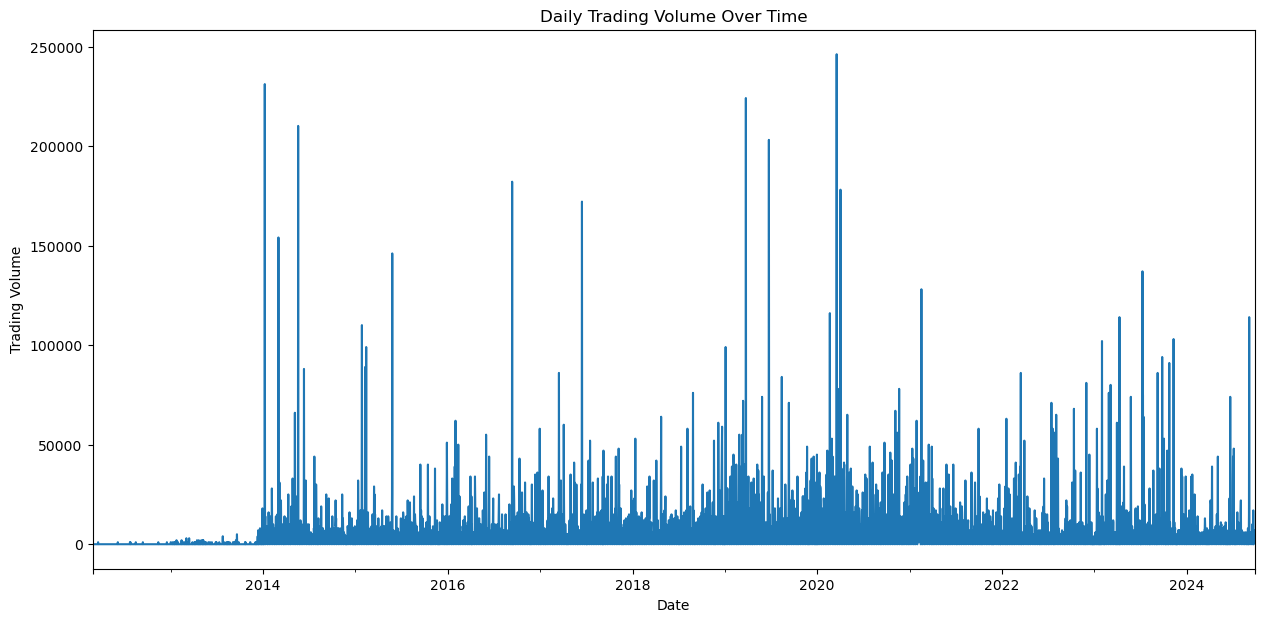


Data types of cleaned DataFrame:
Representative            object
BioGuideID                object
ReportDate        datetime64[ns]
Ticker                    object
Transaction               object
Range                    float64
House                     object
Amount                   float64
Party                     object
last_modified     datetime64[ns]
dtype: object


In [7]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def clean_congress_trading_data(df):
    print("Original shape:", df.shape)
    
    # Remove rows with any null values
    df = df.dropna()
    print("Shape after removing null values:", df.shape)
    
    # Convert date columns to datetime
    date_columns = ['ReportDate', 'TransactionDate', 'last_modified']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Remove rows where date conversion failed
    df = df.dropna(subset=date_columns)
    print("Shape after date conversion:", df.shape)
    
    # Clean and standardize text columns
    text_columns = ['Representative', 'BioGuideID', 'Ticker', 'Transaction', 'House', 'Party']
    for col in text_columns:
        df[col] = df[col].str.strip().str.upper()
    
    # Handle the 'Amount' column
    df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
    df = df.dropna(subset=['Amount'])
    print("Shape after cleaning Amount column:", df.shape)
    
    # Handle the 'Range' column
    def extract_range_value(range_str):
        try:
            range_str = range_str.replace('$', '').replace(',', '')
            lower, upper = map(float, range_str.split('-'))
            return (lower + upper) / 2
        except:
            return np.nan
    
    df['Range'] = df['Range'].apply(extract_range_value)
    df = df.dropna(subset=['Range'])
    print("Shape after cleaning Range column:", df.shape)
    
    # Remove outliers using IQR method
    for col in ['Amount', 'Range']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    print("Shape after removing outliers:", df.shape)
    
    # Remove duplicates
    df = df.drop_duplicates()
    print("Shape after removing duplicates:", df.shape)
    
    # Ensure data consistency
    df = df[df['TransactionDate'] <= df['ReportDate']]
    df = df[df['TransactionDate'] >= '2012-01-01']  # Assuming data starts from 2012
    print("Shape after ensuring data consistency:", df.shape)
    
    # Remove rows where Party is 'I'
    df = df[df['Party'] != 'I']
    print("Shape after removing Independent party rows:", df.shape)
    
    return df

def prepare_congress_trading_timeseries(df):
    # Clean the data first
    df = clean_congress_trading_data(df)
    
    # Set 'TransactionDate' as the index
    df.set_index('TransactionDate', inplace=True)
    
    # Sort the index
    df.sort_index(inplace=True)
    
    print("\nFirst few rows of the cleaned dataframe:")
    print(df.head())
    
    # Save the cleaned data to a new CSV file
    cleaned_csv_path = 'all_congress_cleaned_data.csv'
    df.to_csv(cleaned_csv_path)
    print(f"\nCleaned data saved to {cleaned_csv_path}")
    
    # Resample the data to daily frequency, summing the 'Amount'
    daily_trading = df.resample('D')['Amount'].sum().fillna(0)
    
    print("\nTime series data prepared. Shape:", daily_trading.shape)
    print("\nFirst few rows of the time series:")
    print(daily_trading.head())
    
    return df, daily_trading

# Assuming 'df' is your original dataframe
cleaned_df, time_series_data = prepare_congress_trading_timeseries(df)

# Plot the time series
plt.figure(figsize=(15, 7))
time_series_data.plot()
plt.title('Daily Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Trading Volume')
plt.show()

# Print data types of cleaned_df
print("\nData types of cleaned DataFrame:")
print(cleaned_df.dtypes)

In [8]:
# Assuming cleaned_df is already available and has 'TransactionDate' as the index

# Filter the data from January 1, 2019 onwards
df_2019_onwards = cleaned_df.loc['2019-01-01':]

# Reset the index to make 'TransactionDate' a regular column again
df_2019_onwards = df_2019_onwards.reset_index()

# Save the filtered data to a new CSV file
output_csv_path = 'congress_trading_2019_onwards.csv'
df_2019_onwards.to_csv(output_csv_path, index=False)

print(f"Data from 2019 onwards saved to {output_csv_path}")
print(f"Shape of the new dataframe: {df_2019_onwards.shape}")
print("\nFirst few rows of the new dataframe:")
print(df_2019_onwards.head())

# Display data types of the new dataframe
print("\nData types of the new DataFrame:")
print(df_2019_onwards.dtypes)

Data from 2019 onwards saved to congress_trading_2019_onwards.csv
Shape of the new dataframe: (19554, 11)

First few rows of the new dataframe:
  TransactionDate    Representative BioGuideID ReportDate Ticker Transaction  \
0      2019-01-02  GILBERT CISNEROS    C001123 2019-02-13    SCG    EXCHANGE   
1      2019-01-02       LAMAR SMITH    S000583 2019-01-10   PTLA    PURCHASE   
2      2019-01-02   EARL BLUMENAUER    B000574 2019-01-16     WY    PURCHASE   
3      2019-01-02   JOHN RUTHERFORD    R000609 2019-01-02    ING        SALE   
4      2019-01-02       JACKY ROSEN    R000608 2019-02-21   DELL    EXCHANGE   

    Range            House  Amount Party last_modified  
0  8000.5  REPRESENTATIVES  1001.0     D    2023-11-16  
1  8000.5  REPRESENTATIVES  1001.0     R    2023-11-16  
2  8000.5  REPRESENTATIVES  1001.0     D    2023-11-16  
3  8000.5  REPRESENTATIVES  1001.0     R    2023-11-16  
4  8000.5  REPRESENTATIVES  1001.0     D    2023-11-16  

Data types of the new DataFrame:

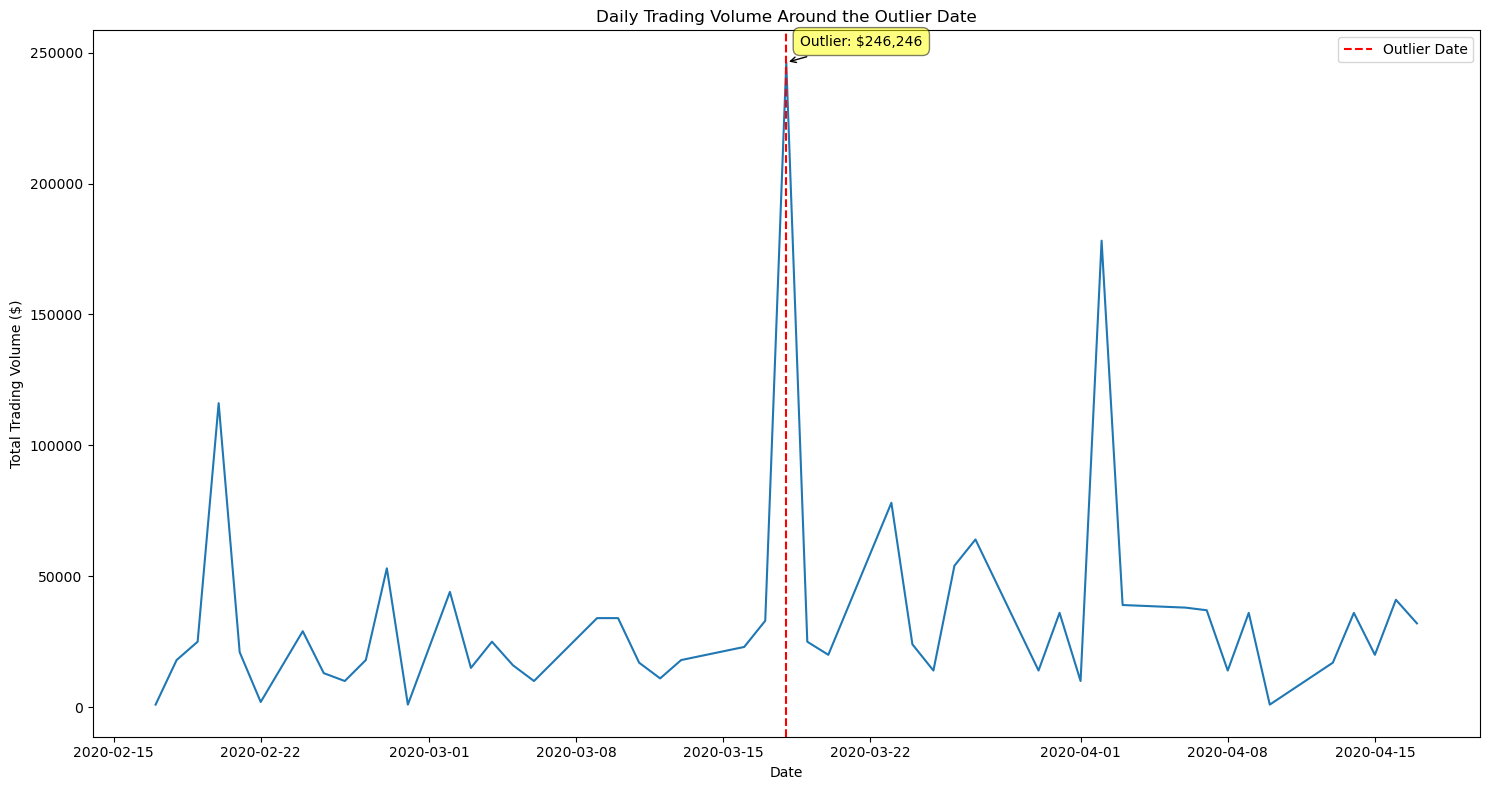

Outlier Date: 2020-03-18 00:00:00
Outlier Trading Volume: $246,246.00

Top 5 transactions on the outlier date:
     TransactionDate      Representative BioGuideID  ReportDate Ticker  \
5568      2020-03-18    GILBERT CISNEROS    C001123  2020-04-16   NTRS   
5722      2020-03-18  K. MICHAEL CONAWAY    C001062  2020-04-06    DEO   
5724      2020-03-18    GILBERT CISNEROS    C001123  2020-04-16    JEF   
5725      2020-03-18    GILBERT CISNEROS    C001123  2020-04-16      F   
5726      2020-03-18    GILBERT CISNEROS    C001123  2020-04-16   COTY   

     Transaction   Range            House  Amount Party last_modified  
5568    PURCHASE  8000.5  REPRESENTATIVES  1001.0     D    2023-11-16  
5722        SALE  8000.5  REPRESENTATIVES  1001.0     R    2023-11-16  
5724        SALE  8000.5  REPRESENTATIVES  1001.0     D    2023-11-16  
5725    PURCHASE  8000.5  REPRESENTATIVES  1001.0     D    2023-11-16  
5726        SALE  8000.5  REPRESENTATIVES  1001.0     D    2023-11-16  


' The outlier date is March 13, 2020. This is a particularly significant time in recent history. \nLet\'s look at the events of that week and explain why this outlier in Congressional transactions may \nhave occurred.\n\nHistorical Context and Relevant Events (Week of March 9-15, 2020): COVID-19 Pandemic: March 11: \nWHO officially declares COVID-19 a global pandemic.\nThis week marks the start of mass lockdowns and confinement measures in many countries.\n\nFinancial Market Crisis: March 9: The US stock market experiences its worst drop since 2008.\n March 12: The Dow Jones Index drops 10%, the largest percentage drop since "Black Monday" in 1987.\n   March 13: President Trump declares a national emergency due to COVID-19.\n\nEconomic Response: Discussions about economic stimulus packages begin to intensify.\nThe Federal Reserve announces emergency measures to support the economy.\n\nHealthcare Sector: Dramatic increase in demand for medical equipment, tests, and potential treatments.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Load the data
df = pd.read_csv('congress_trading_2019_onwards.csv')
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Calculate daily trading volume
daily_volume = df.groupby('TransactionDate')['Amount'].sum().reset_index()

# Identify the outlier (assuming it's the highest trading volume day)
outlier_date = daily_volume.loc[daily_volume['Amount'].idxmax(), 'TransactionDate']

# Create a window around the outlier date
window_start = outlier_date - timedelta(days=30)
window_end = outlier_date + timedelta(days=30)

# Filter data for the window period
window_data = daily_volume[(daily_volume['TransactionDate'] >= window_start) & 
                           (daily_volume['TransactionDate'] <= window_end)]

# Create the plot
plt.figure(figsize=(15, 8))
sns.lineplot(x='TransactionDate', y='Amount', data=window_data)
plt.axvline(x=outlier_date, color='r', linestyle='--', label='Outlier Date')
plt.title('Daily Trading Volume Around the Outlier Date')
plt.xlabel('Date')
plt.ylabel('Total Trading Volume ($)')
plt.legend()

# Annotate the outlier point
max_amount = window_data.loc[window_data['TransactionDate'] == outlier_date, 'Amount'].values[0]
plt.annotate(f'Outlier: ${max_amount:,.0f}', 
             xy=(outlier_date, max_amount), 
             xytext=(10, 10), 
             textcoords='offset points', 
             ha='left', 
             va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

print(f"Outlier Date: {outlier_date}")
print(f"Outlier Trading Volume: ${max_amount:,.2f}")

# Additional analysis: Transactions on the outlier date
outlier_transactions = df[df['TransactionDate'] == outlier_date]
print("\nTop 5 transactions on the outlier date:")
print(outlier_transactions.sort_values('Amount', ascending=False).head())


''' The outlier date is March 13, 2020. This is a particularly significant time in recent history. 
Let's look at the events of that week and explain why this outlier in Congressional transactions may 
have occurred.

Historical Context and Relevant Events (Week of March 9-15, 2020): COVID-19 Pandemic: March 11: 
WHO officially declares COVID-19 a global pandemic.
This week marks the start of mass lockdowns and confinement measures in many countries.

Financial Market Crisis: March 9: The US stock market experiences its worst drop since 2008.
 March 12: The Dow Jones Index drops 10%, the largest percentage drop since "Black Monday" in 1987.
   March 13: President Trump declares a national emergency due to COVID-19.

Economic Response: Discussions about economic stimulus packages begin to intensify.
The Federal Reserve announces emergency measures to support the economy.

Healthcare Sector: Dramatic increase in demand for medical equipment, tests, and potential treatments.

Outlier Explanation: Market Panic Reaction: The high trading volume likely reflects a reaction by members
 of Congress to the market crash. Many could be selling stocks to minimize losses or buying on the dip, 
 anticipating a recovery.

Insider Information: Members of Congress could have had access to insider information about the severity 
of the pandemic and its potential economic impacts before the general public.

Policy Anticipation: Advance knowledge of potential economic stimulus measures or public health policies
 could have influenced trading decisions.

Portfolio Adjustment: The declaration of a pandemic and national emergency likely led many to reconsider 
their investments, adjusting their portfolios for a new economic landscape.

Sectoral Opportunities: Some members might have invested heavily in sectors expected to benefit from 
the pandemic (e.g., technology, healthcare) while selling into vulnerable sectors (e.g., tourism, airlines).

Emergency Liquidity: Some might have sold stocks to secure liquidity in the face of economic uncertainty.

Response to Emergency Declaration: The declaration of a national emergency on the same day as the outlier 
likely catalyzed many trading decisions.

This outlier is particularly important because it occurs at a time of national and global crisis.
 It raises ethical questions about insider trading and the need for greater transparency in the financial 
 dealings of elected officials. It also highlights how global events can directly influence the financial 
 behavior of lawmakers, potentially affecting their policy and legislative decisions.
This event underscores the importance of carefully analyzing the transactions of members of Congress, 
especially during periods of crisis, to ensure the integrity of the legislative process
 and public confidence in their elected representatives.'''